# Module 4: Evaluation Metrics - NDCG@K and Precision@K

**Goal**: Evaluate ranking quality using NDCG@K and Precision@K metrics.

**Two-Tier Evaluation:**
1. **Relevance-Based**: Is the video about the skill?
2. **Quality-Based**: Is it a HIGH-QUALITY video?

**Ground Truth**: LLM-generated labels from `labeled_videos.csv` (Gemini Top-5 chunk aggregation)

## Setup

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import json
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Paths
DATA_DIR = Path('../data/processed')
RESULTS_DIR = Path('../results/baselines')
EVAL_DIR = Path('../results/evaluation')

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
EVAL_DIR.mkdir(parents=True, exist_ok=True)

## Load Data

In [ ]:
# Load ground truth labels (Gemini Top-5 chunk aggregation)
labels_df = pd.read_csv(DATA_DIR / 'labeled_videos.csv')

# Load model rankings
bm25_rankings = pd.read_csv(RESULTS_DIR / 'bm25_rankings.csv')
sbert_rankings = pd.read_csv(RESULTS_DIR / 'sbert_rankings.csv')

# Load Cross-Encoder zero-shot scores
zeroshot_df = pd.read_csv(RESULTS_DIR / 'zeroshot_scores.csv')

# Load Cross-Encoder Fine-Tuned scores
finetuned_path = Path('../results/model/cross_encoder_finetuned_predictions.csv')
if finetuned_path.exists():
    finetuned_df = pd.read_csv(finetuned_path)
    print(f"Cross-Encoder Fine-Tuned chunks: {len(finetuned_df)} chunk scores")
else:
    print(f"Fine-tuned predictions not found at {finetuned_path}")
    finetuned_df = None

print(f"Loaded {len(labels_df)} labeled video-skill pairs")
print(f"BM25 rankings:  {len(bm25_rankings)} skill-video pairs")
print(f"SBERT rankings: {len(sbert_rankings)} skill-video pairs")
print(f"Cross-Encoder Zero-Shot chunks: {len(zeroshot_df)} chunk scores")
print(f"\nLabel columns: {list(labels_df.columns)}")

Cross-Encoder Fine-Tuned chunks: 12170 chunk scores
Loaded 384 labeled video-skill pairs
BM25 rankings:  3072 skill-video pairs
SBERT rankings: 3072 skill-video pairs
Cross-Encoder Zero-Shot chunks: 12198 chunk scores

Label columns: ['video_id', 'skill_id', 'traditional_relevance', 'depth', 'clarity', 'practical_examples', 'instructional_language', 'chunk_count']


In [ ]:
# Check for duplicate video_ids
print("Checking for duplicate video_ids in labeled_videos.csv...")
print(f"Total rows: {len(labels_df)}")
print(f"Unique videos: {labels_df['video_id'].nunique()}")
print(f"Unique skills: {labels_df['skill_id'].nunique()}")

# Check for duplicate video_ids (same video appearing multiple times)
video_duplicates = labels_df['video_id'].duplicated().sum()
print(f"\nDuplicate video_ids: {video_duplicates}")

if video_duplicates > 0:
    print("\nVideos appearing in multiple rows:")
    dup_videos = labels_df[labels_df['video_id'].duplicated(keep=False)].sort_values('video_id')
    print(dup_videos[['video_id', 'skill_id', 'title', 'traditional_relevance']])

    print(f"\nNote: Videos can legitimately appear multiple times if labeled for different skills")
else:
    print("\nEach video appears exactly once (no multi-skill labeling)")

Checking for duplicate video_ids in labeled_videos.csv...
Total rows: 384
Unique videos: 384
Unique skills: 8

Duplicate video_ids: 0

Each video appears exactly once (no multi-skill labeling)


## Aggregate Cross-Encoder Scores to Video Level (Top-5)

In [ ]:
# Aggregate Cross-Encoder chunk scores to video level using Top-5 mean
# This is the same aggregation method used for the ground truth labels

def aggregate_top_k(group, k=5):
    """Get mean of top-k scores for a video"""
    return group.nlargest(k, 'score')['score'].mean()

# Group by video and skill, then aggregate
zeroshot_video_scores = zeroshot_df.groupby(['video_id', 'skill_id']).apply(aggregate_top_k).reset_index()
zeroshot_video_scores.columns = ['video_id', 'skill_id', 'score']

print(f"Aggregated {len(zeroshot_df)} chunk scores to {len(zeroshot_video_scores)} video-level scores")
print(f"\nScore statistics:")
print(zeroshot_video_scores['score'].describe())

# Create rankings from Cross-Encoder scores (higher score = better rank)
zeroshot_rankings = zeroshot_video_scores.copy()
zeroshot_rankings['rank'] = zeroshot_rankings.groupby('skill_id')['score'].rank(ascending=False, method='first').astype(int)
zeroshot_rankings = zeroshot_rankings.sort_values(['skill_id', 'rank'])

print(f"\n Created Cross-Encoder rankings for {zeroshot_rankings['skill_id'].nunique()} skills")

Aggregated 12198 chunk scores to 389 video-level scores

Score statistics:
count    389.000000
mean      -2.528296
std        2.972657
min      -10.451823
25%       -4.523513
50%       -2.523473
75%       -0.443294
max        5.511344
Name: score, dtype: float64

 Created Cross-Encoder rankings for 8 skills


In [ ]:
# Aggregate Fine-Tuned Cross-Encoder scores
if finetuned_df is not None:
    # Group by video and skill, then aggregate
    finetuned_video_scores = finetuned_df.groupby(['video_id', 'skill_id']).apply(aggregate_top_k).reset_index()
    finetuned_video_scores.columns = ['video_id', 'skill_id', 'score']

    print(f"Aggregated {len(finetuned_df)} fine-tuned chunk scores to {len(finetuned_video_scores)} video-level scores")
    print(f"\nFine-Tuned Score statistics:")
    print(finetuned_video_scores['score'].describe())

    # Create rankings
    finetuned_rankings = finetuned_video_scores.copy()
    finetuned_rankings['rank'] = finetuned_rankings.groupby('skill_id')['score'].rank(ascending=False, method='first').astype(int)
    finetuned_rankings = finetuned_rankings.sort_values(['skill_id', 'rank'])

    print(f"\n Created Fine-Tuned Cross-Encoder rankings for {finetuned_rankings['skill_id'].nunique()} skills")
else:
    finetuned_rankings = None
    print("Skipping fine-tuned aggregation (data not found)")

Aggregated 12170 fine-tuned chunk scores to 384 video-level scores

Fine-Tuned Score statistics:
count    384.000000
mean       0.551223
std        0.733970
min       -1.947337
25%        0.224722
50%        0.727011
75%        1.026287
max        1.959361
Name: score, dtype: float64

 Created Fine-Tuned Cross-Encoder rankings for 8 skills


## Filter Labels to Videos with Transcripts

In [ ]:
# Check which labeled videos actually have transcripts
transcripts_df = pd.read_csv(DATA_DIR / 'transcripts_cleaned.csv')
videos_with_transcripts = set(transcripts_df['video_id'].unique())
labeled_videos = set(labels_df['video_id'].unique())

print(f"\nTranscript Coverage Check:")
print(f"Videos with transcripts: {len(videos_with_transcripts)}")
print(f"Unique labeled videos: {len(labeled_videos)}")

# Find labeled videos WITHOUT transcripts
missing_transcripts = labeled_videos - videos_with_transcripts
if len(missing_transcripts) > 0:
    print(f"\n WARNING: {len(missing_transcripts)} labeled videos are missing transcripts!")
    print(f"These videos won't be in your SBERT rankings.")
    print(f"\nSample missing videos: {list(missing_transcripts)[:5]}")
else:
    print(f"\n All labeled videos have transcripts")

# Find videos WITH transcripts but NOT labeled
unlabeled_videos = videos_with_transcripts - labeled_videos
if len(unlabeled_videos) > 0:
    print(f"\n {len(unlabeled_videos)} videos have transcripts but no labels (not evaluated)")
else:
    print(f"\n All videos with transcripts have labels")


Transcript Coverage Check:
Videos with transcripts: 384
Unique labeled videos: 384

 All labeled videos have transcripts

 All videos with transcripts have labels


In [ ]:
# Filter labels to only include videos that have transcripts
# This ensures we only evaluate videos that can actually be ranked by SBERT
print("Filtering labels to videos with transcripts...")
print(f"Before filtering: {len(labels_df)} labeled video-skill pairs ({labels_df['video_id'].nunique()} unique videos)")

labels_df = labels_df[labels_df['video_id'].isin(videos_with_transcripts)].copy()

print(f"After filtering:  {len(labels_df)} labeled video-skill pairs ({labels_df['video_id'].nunique()} unique videos)")
print(f"\n Filtered out {len(missing_transcripts)} videos without transcripts")
print(f" All remaining labeled videos can be ranked by SBERT")

Filtering labels to videos with transcripts...
Before filtering: 384 labeled video-skill pairs (384 unique videos)
After filtering:  384 labeled video-skill pairs (384 unique videos)

 Filtered out 0 videos without transcripts
 All remaining labeled videos can be ranked by SBERT


## Explore Label Distributions

Label Distribution:

Traditional Relevance:
traditional_relevance
1.000000      4
1.333333      3
1.400000      1
1.500000      3
1.600000      1
1.666667      1
1.750000      2
1.800000      2
2.000000     13
2.200000      4
2.333333      2
2.400000      2
2.500000      3
2.600000      3
2.666667      2
2.800000      3
3.000000     10
3.200000      8
3.250000      3
3.333333      1
3.400000      3
3.500000      4
3.600000      4
3.666667      4
3.750000      3
3.800000     10
4.000000     17
4.200000     16
4.333333      3
4.400000     20
4.500000      3
4.600000     37
4.666667      4
4.750000      2
4.800000     25
5.000000    158
Name: count, dtype: int64


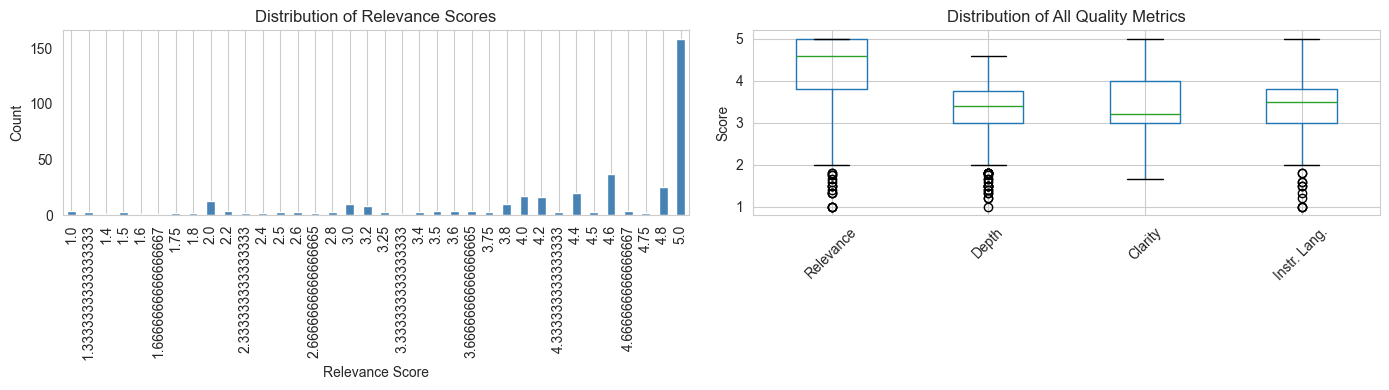

In [ ]:
# Explore label distributions
print("Label Distribution:")
print(f"\nTraditional Relevance:")
print(labels_df['traditional_relevance'].value_counts().sort_index())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Relevance distribution
labels_df['traditional_relevance'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Relevance Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Relevance Scores')
axes[0].grid(axis='y')

# All metrics
metrics_to_plot = ['traditional_relevance', 'depth', 'clarity', 'instructional_language']
labels_df[metrics_to_plot].boxplot(ax=axes[1])
axes[1].set_ylabel('Score')
axes[1].set_title('Distribution of All Quality Metrics')
axes[1].set_xticklabels(['Relevance', 'Depth', 'Clarity', 'Instr. Lang.'], rotation=45)

plt.tight_layout()
plt.show()

---
## PART 1: Relevance-Based Evaluation

**Question**: Does SBERT find videos that are **on-topic** for each skill?

In [ ]:
# Define relevance threshold
# Videos with traditional_relevance >= 3 are considered "relevant"
RELEVANCE_THRESHOLD = 4

# Create binary relevance labels
labels_df['is_relevant'] = (labels_df['traditional_relevance'] >= RELEVANCE_THRESHOLD).astype(int)

print(f"Using relevance threshold: {RELEVANCE_THRESHOLD}")
print(f"\nRelevant videos: {labels_df['is_relevant'].sum()} ({labels_df['is_relevant'].mean()*100:.1f}%)")
print(f"Non-relevant videos: {(1 - labels_df['is_relevant']).sum()} ({(1 - labels_df['is_relevant']).mean()*100:.1f}%)")

Using relevance threshold: 4

Relevant videos: 285 (74.2%)
Non-relevant videos: 99 (25.8%)


### Evaluation Metrics Implementation

In [ ]:
def precision_at_k(ranked_items: List[str], relevant_items: set, k: int) -> float:
    """
    Calculate Precision@K.
    Precision@K = (# relevant items in top-K) / K
    """
    if k == 0 or len(ranked_items) == 0:
        return 0.0

    top_k = ranked_items[:k]
    relevant_in_top_k = sum(1 for item in top_k if item in relevant_items)
    return relevant_in_top_k / k


def dcg_at_k(ranked_items: List[str], relevance_scores: Dict[str, float], k: int) -> float:
    """
    Calculate Discounted Cumulative Gain at K.
    DCG@K = sum(rel_i / log2(i + 1)) for i in 1..K
    """
    dcg = 0.0
    for i, item in enumerate(ranked_items[:k], start=1):
        rel = relevance_scores.get(item, 0)
        dcg += rel / np.log2(i + 1)
    return dcg


def ndcg_at_k(ranked_items: List[str], relevance_scores: Dict[str, float], k: int) -> float:
    """
    Calculate Normalized Discounted Cumulative Gain at K.
    NDCG@K = DCG@K / IDCG@K
    """
    dcg = dcg_at_k(ranked_items, relevance_scores, k)

    # Calculate ideal DCG@K
    ideal_ranking = sorted(relevance_scores.keys(), key=lambda x: relevance_scores[x], reverse=True)
    idcg = dcg_at_k(ideal_ranking, relevance_scores, k)

    if idcg == 0:
        return 0.0

    return dcg / idcg


print(" Evaluation functions defined")

 Evaluation functions defined


In [ ]:
def evaluate_rankings(
    rankings_df: pd.DataFrame,
    labels_df: pd.DataFrame,
    k: int = 10
) -> pd.DataFrame:
    """
    Evaluate ranking quality using NDCG@K and Precision@K (relevance-based).
    """
    results = []
    skills = rankings_df['skill_id'].unique()

    for skill_id in skills:
        skill_rankings = rankings_df[rankings_df['skill_id'] == skill_id].sort_values('rank')
        ranked_videos = skill_rankings['video_id'].tolist()

        skill_labels = labels_df[labels_df['skill_id'] == skill_id]
        relevance_scores = dict(zip(skill_labels['video_id'], skill_labels['traditional_relevance']))
        relevant_videos = set(skill_labels[skill_labels['is_relevant'] == 1]['video_id'])

        precision = precision_at_k(ranked_videos, relevant_videos, k)
        ndcg = ndcg_at_k(ranked_videos, relevance_scores, k)

        results.append({
            'skill_id': skill_id,
            'k': k,
            'precision_at_k': precision,
            'ndcg_at_k': ndcg
        })

    return pd.DataFrame(results)


print(" Evaluation pipeline defined")

 Evaluation pipeline defined


### Evaluate BM25 Rankings (Relevance-Based)

In [ ]:
# Evaluate BM25 at K=10
print("Evaluating BM25 rankings (K=10)...")
bm25_eval = evaluate_rankings(bm25_rankings, labels_df, k=10)

print(f"\n Evaluated {len(bm25_eval)} skills")
print("\nResults:")
print(bm25_eval[['skill_id', 'precision_at_k', 'ndcg_at_k']].to_string(index=False))

Evaluating BM25 rankings (K=10)...

 Evaluated 8 skills

Results:
                       skill_id  precision_at_k  ndcg_at_k
       numpy_array_manipulation             0.8   0.891104
           pandas_data_cleaning             0.8   0.798931
       matplotlib_visualization             0.5   0.643243
         sklearn_model_training             0.6   0.655710
        pytorch_neural_networks             0.7   0.755364
tensorflow_image_classification             0.9   0.920821
            feature_engineering             0.8   0.819137
       model_evaluation_metrics             0.5   0.462681


### BM25 Relevance-Based Results Summary

In [ ]:
bm25_avg_precision = bm25_eval['precision_at_k'].mean()
bm25_avg_ndcg = bm25_eval['ndcg_at_k'].mean()
bm25_relevance_metrics = {
    'model': 'BM25',
    'precision_at_10': bm25_avg_precision,
    'ndcg_at_10': bm25_avg_ndcg
}

print("="*80)
print("BM25 RELEVANCE-BASED PERFORMANCE (K=10)")
print("="*80)
print(f"Average Precision@10: {bm25_avg_precision:.3f}")
print(f"Average NDCG@10:      {bm25_avg_ndcg:.3f}")

print("\n" + "="*80)
print("Per-Skill Performance:")
print("="*80)
bm25_skill_perf = bm25_eval[['skill_id', 'precision_at_k', 'ndcg_at_k']].sort_values('ndcg_at_k', ascending=False)
print(bm25_skill_perf.to_string(index=False))

BM25 RELEVANCE-BASED PERFORMANCE (K=10)
Average Precision@10: 0.700
Average NDCG@10:      0.743

Per-Skill Performance:
                       skill_id  precision_at_k  ndcg_at_k
tensorflow_image_classification             0.9   0.920821
       numpy_array_manipulation             0.8   0.891104
            feature_engineering             0.8   0.819137
           pandas_data_cleaning             0.8   0.798931
        pytorch_neural_networks             0.7   0.755364
         sklearn_model_training             0.6   0.655710
       matplotlib_visualization             0.5   0.643243
       model_evaluation_metrics             0.5   0.462681


### Visualize BM25 Relevance-Based Results

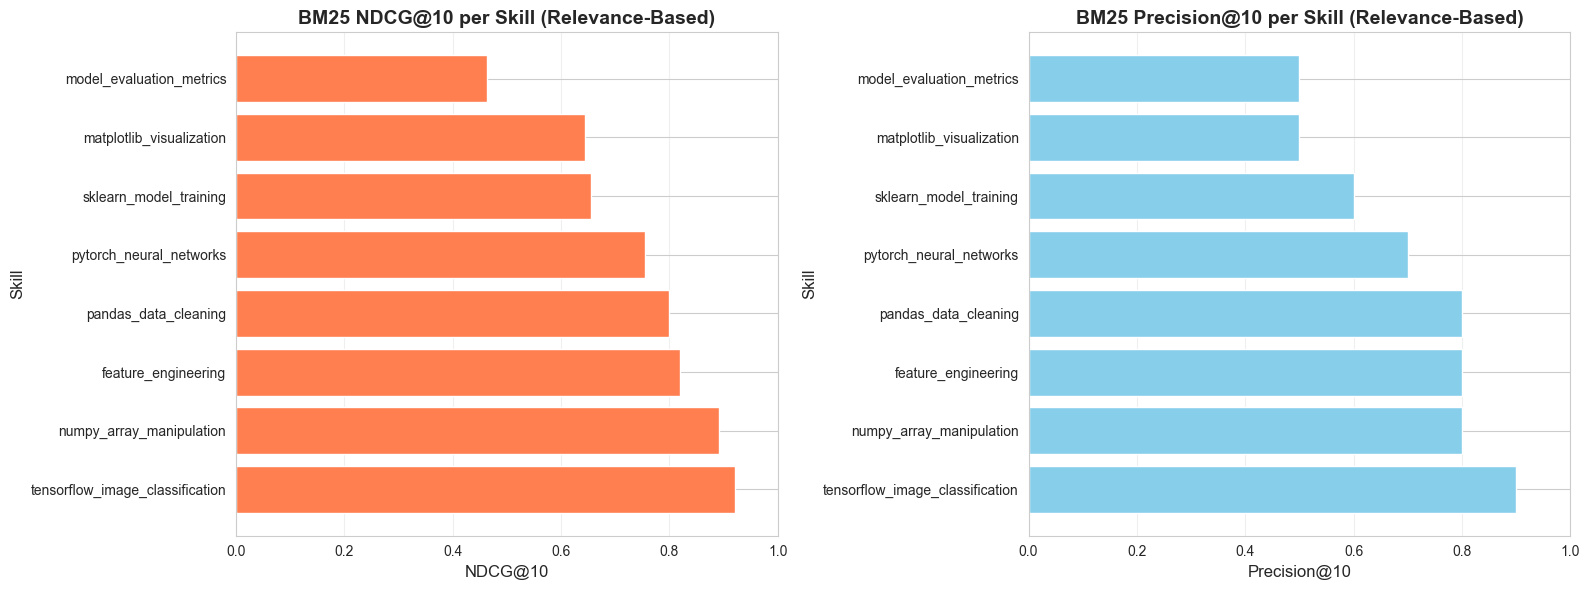

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

bm25_skill_perf_sorted = bm25_eval.sort_values('ndcg_at_k', ascending=False)

axes[0].barh(bm25_skill_perf_sorted['skill_id'], bm25_skill_perf_sorted['ndcg_at_k'], color='coral')
axes[0].set_xlabel('NDCG@10', fontsize=12)
axes[0].set_ylabel('Skill', fontsize=12)
axes[0].set_title('BM25 NDCG@10 per Skill (Relevance-Based)', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(bm25_skill_perf_sorted['skill_id'], bm25_skill_perf_sorted['precision_at_k'], color='skyblue')
axes[1].set_xlabel('Precision@10', fontsize=12)
axes[1].set_ylabel('Skill', fontsize=12)
axes[1].set_title('BM25 Precision@10 per Skill (Relevance-Based)', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(EVAL_DIR / 'bm25_relevance_per_skill.png', dpi=150, bbox_inches='tight')
plt.show()

---
## PART 2: SBERT

### Evaluate SBERT Rankings (Relevance-Based)

In [ ]:
# Evaluate SBERT at K=10
print("Evaluating SBERT rankings (K=10)...")
sbert_eval = evaluate_rankings(sbert_rankings, labels_df, k=10)

print(f"\n Evaluated {len(sbert_eval)} skills")
print("\nResults:")
print(sbert_eval[['skill_id', 'precision_at_k', 'ndcg_at_k']].to_string(index=False))

Evaluating SBERT rankings (K=10)...

 Evaluated 8 skills

Results:
                       skill_id  precision_at_k  ndcg_at_k
       numpy_array_manipulation             0.9   0.885230
           pandas_data_cleaning             0.7   0.778172
       matplotlib_visualization             0.7   0.810800
         sklearn_model_training             0.6   0.713984
        pytorch_neural_networks             0.8   0.908526
tensorflow_image_classification             0.8   0.889197
            feature_engineering             0.4   0.756622
       model_evaluation_metrics             0.7   0.736803


### SBERT Relevance-Based Results Summary

In [ ]:
sbert_avg_precision = sbert_eval['precision_at_k'].mean()
sbert_avg_ndcg = sbert_eval['ndcg_at_k'].mean()
sbert_relevance_metrics = {
    'model': 'SBERT',
    'precision_at_10': sbert_avg_precision,
    'ndcg_at_10': sbert_avg_ndcg
}

print("="*80)
print("SBERT RELEVANCE-BASED PERFORMANCE (K=10)")
print("="*80)
print(f"Average Precision@10: {sbert_avg_precision:.3f}")
print(f"Average NDCG@10:      {sbert_avg_ndcg:.3f}")

print("\n" + "="*80)
print("Per-Skill Performance:")
print("="*80)
sbert_skill_perf = sbert_eval[['skill_id', 'precision_at_k', 'ndcg_at_k']].sort_values('ndcg_at_k', ascending=False)
print(sbert_skill_perf.to_string(index=False))

SBERT RELEVANCE-BASED PERFORMANCE (K=10)
Average Precision@10: 0.700
Average NDCG@10:      0.810

Per-Skill Performance:
                       skill_id  precision_at_k  ndcg_at_k
        pytorch_neural_networks             0.8   0.908526
tensorflow_image_classification             0.8   0.889197
       numpy_array_manipulation             0.9   0.885230
       matplotlib_visualization             0.7   0.810800
           pandas_data_cleaning             0.7   0.778172
            feature_engineering             0.4   0.756622
       model_evaluation_metrics             0.7   0.736803
         sklearn_model_training             0.6   0.713984


### Visualize SBERT Relevance-Based Results

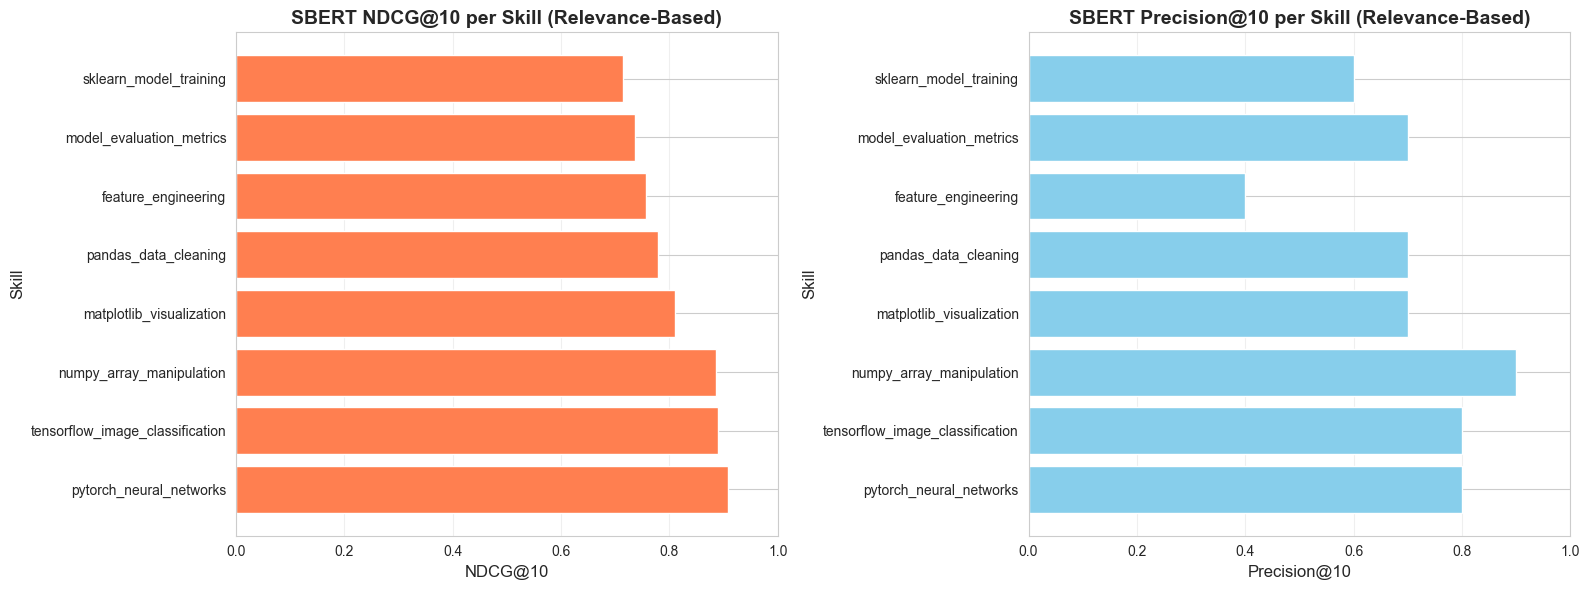

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sbert_skill_perf_sorted = sbert_eval.sort_values('ndcg_at_k', ascending=False)

axes[0].barh(sbert_skill_perf_sorted['skill_id'], sbert_skill_perf_sorted['ndcg_at_k'], color='coral')
axes[0].set_xlabel('NDCG@10', fontsize=12)
axes[0].set_ylabel('Skill', fontsize=12)
axes[0].set_title('SBERT NDCG@10 per Skill (Relevance-Based)', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(sbert_skill_perf_sorted['skill_id'], sbert_skill_perf_sorted['precision_at_k'], color='skyblue')
axes[1].set_xlabel('Precision@10', fontsize=12)
axes[1].set_ylabel('Skill', fontsize=12)
axes[1].set_title('SBERT Precision@10 per Skill (Relevance-Based)', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(EVAL_DIR / 'sbert_relevance_per_skill.png', dpi=150, bbox_inches='tight')
plt.show()

---
## PART 3: Cross-Encoder (Zero-Shot)

### Evaluate Cross-Encoder Rankings (Relevance-Based)

In [ ]:
# Evaluate Cross-Encoder at K=10
print("Evaluating Cross-Encoder (Zero-Shot) rankings (K=10)...")
crossencoder_eval = evaluate_rankings(zeroshot_rankings, labels_df, k=10)

print(f"\n Evaluated {len(crossencoder_eval)} skills")
print("\nResults:")
print(crossencoder_eval[['skill_id', 'precision_at_k', 'ndcg_at_k']].to_string(index=False))

Evaluating Cross-Encoder (Zero-Shot) rankings (K=10)...

 Evaluated 8 skills

Results:
                       skill_id  precision_at_k  ndcg_at_k
            feature_engineering             0.9   0.891832
       matplotlib_visualization             0.8   0.852590
       model_evaluation_metrics             1.0   0.958090
       numpy_array_manipulation             0.9   0.939818
           pandas_data_cleaning             0.8   0.861684
        pytorch_neural_networks             0.9   0.944352
         sklearn_model_training             0.8   0.862988
tensorflow_image_classification             0.9   0.929495


### Cross-Encoder Relevance-Based Results Summary

In [ ]:
crossencoder_avg_precision = crossencoder_eval['precision_at_k'].mean()
crossencoder_avg_ndcg = crossencoder_eval['ndcg_at_k'].mean()
crossencoder_relevance_metrics = {
    'model': 'Cross-Encoder (Zero-Shot)',
    'precision_at_10': crossencoder_avg_precision,
    'ndcg_at_10': crossencoder_avg_ndcg
}

print("="*80)
print("CROSS-ENCODER (ZERO-SHOT) RELEVANCE-BASED PERFORMANCE (K=10)")
print("="*80)
print(f"Average Precision@10: {crossencoder_avg_precision:.3f}")
print(f"Average NDCG@10:      {crossencoder_avg_ndcg:.3f}")

print("\n" + "="*80)
print("Per-Skill Performance:")
print("="*80)
crossencoder_skill_perf = crossencoder_eval[['skill_id', 'precision_at_k', 'ndcg_at_k']].sort_values('ndcg_at_k', ascending=False)
print(crossencoder_skill_perf.to_string(index=False))

CROSS-ENCODER (ZERO-SHOT) RELEVANCE-BASED PERFORMANCE (K=10)
Average Precision@10: 0.875
Average NDCG@10:      0.905

Per-Skill Performance:
                       skill_id  precision_at_k  ndcg_at_k
       model_evaluation_metrics             1.0   0.958090
        pytorch_neural_networks             0.9   0.944352
       numpy_array_manipulation             0.9   0.939818
tensorflow_image_classification             0.9   0.929495
            feature_engineering             0.9   0.891832
         sklearn_model_training             0.8   0.862988
           pandas_data_cleaning             0.8   0.861684
       matplotlib_visualization             0.8   0.852590


### Visualize Cross-Encoder Relevance-Based Results

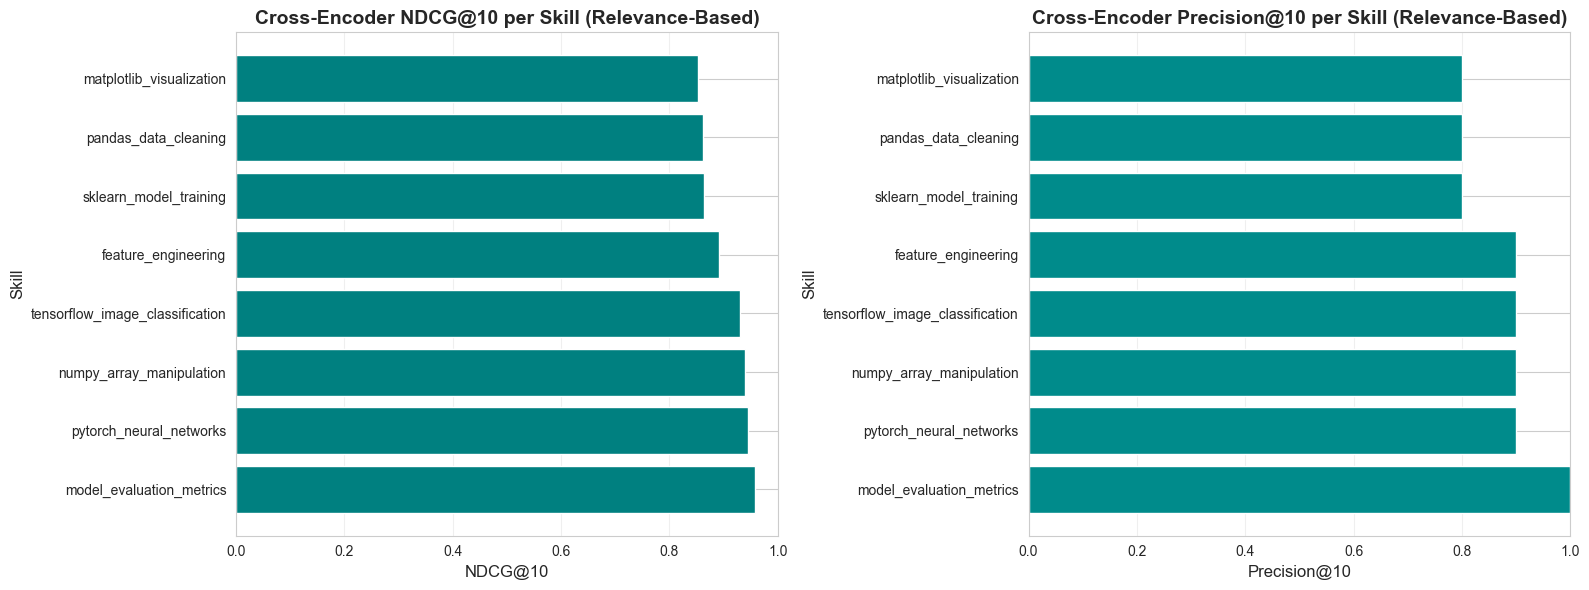

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

crossencoder_skill_perf_sorted = crossencoder_eval.sort_values('ndcg_at_k', ascending=False)

axes[0].barh(crossencoder_skill_perf_sorted['skill_id'], crossencoder_skill_perf_sorted['ndcg_at_k'], color='teal')
axes[0].set_xlabel('NDCG@10', fontsize=12)
axes[0].set_ylabel('Skill', fontsize=12)
axes[0].set_title('Cross-Encoder NDCG@10 per Skill (Relevance-Based)', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(crossencoder_skill_perf_sorted['skill_id'], crossencoder_skill_perf_sorted['precision_at_k'], color='darkcyan')
axes[1].set_xlabel('Precision@10', fontsize=12)
axes[1].set_ylabel('Skill', fontsize=12)
axes[1].set_title('Cross-Encoder Precision@10 per Skill (Relevance-Based)', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(EVAL_DIR / 'crossencoder_relevance_per_skill.png', dpi=150, bbox_inches='tight')
plt.show()

---
## PART 4: Cross-Encoder (Fine-Tuned)

In [ ]:
### Evaluate Cross-Encoder (Fine-Tuned) Rankings (Relevance-Based)
if finetuned_rankings is not None:
    print("Evaluating Cross-Encoder (Fine-Tuned) rankings (K=10)...")
    finetuned_eval = evaluate_rankings(finetuned_rankings, labels_df, k=10)

    print(f"\n Evaluated {len(finetuned_eval)} skills")
    print("\nResults:")
    print(finetuned_eval[['skill_id', 'precision_at_k', 'ndcg_at_k']].to_string(index=False))

    # Summary
    finetuned_avg_precision = finetuned_eval['precision_at_k'].mean()
    finetuned_avg_ndcg = finetuned_eval['ndcg_at_k'].mean()
    finetuned_relevance_metrics = {
        'model': 'Cross-Encoder (Fine-Tuned)',
        'precision_at_10': finetuned_avg_precision,
        'ndcg_at_10': finetuned_avg_ndcg
    }

    print("="*80)
    print("CROSS-ENCODER (FINE-TUNED) RELEVANCE-BASED PERFORMANCE (K=10)")
    print("="*80)
    print(f"Average Precision@10: {finetuned_avg_precision:.3f}")
    print(f"Average NDCG@10:      {finetuned_avg_ndcg:.3f}")
else:
    print("Skipping Fine-Tuned evaluation")
    finetuned_avg_precision = 0
    finetuned_avg_ndcg = 0
    finetuned_relevance_metrics = {'model': 'Cross-Encoder (Fine-Tuned)', 'precision_at_10': 0, 'ndcg_at_10': 0}

Evaluating Cross-Encoder (Fine-Tuned) rankings (K=10)...

 Evaluated 8 skills

Results:
                       skill_id  precision_at_k  ndcg_at_k
            feature_engineering             0.9   0.965520
       matplotlib_visualization             1.0   1.000000
       model_evaluation_metrics             1.0   1.000000
       numpy_array_manipulation             1.0   1.000000
           pandas_data_cleaning             1.0   0.988131
        pytorch_neural_networks             1.0   0.997350
         sklearn_model_training             0.9   0.974753
tensorflow_image_classification             1.0   0.997350
CROSS-ENCODER (FINE-TUNED) RELEVANCE-BASED PERFORMANCE (K=10)
Average Precision@10: 0.975
Average NDCG@10:      0.990


# Quality-Based Evaluation

Quality Score Statistics:
count    384.000000
mean       3.585605
std        0.721339
min        1.380000
25%        3.300000
50%        3.855000
75%        4.110000
max        4.510000
Name: quality_score, dtype: float64

Quality score range: [1.38, 4.51]


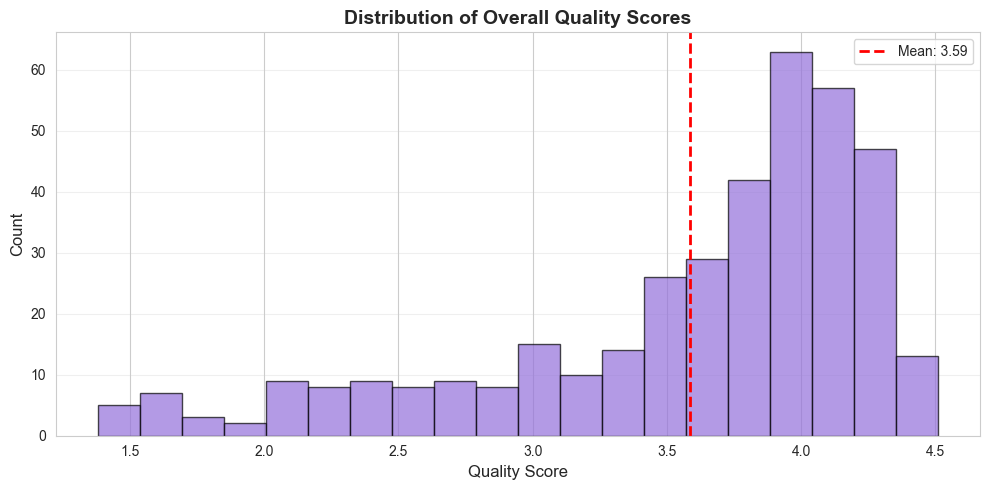

In [ ]:
def calculate_quality_score(row):
    """
    Calculate overall quality score combining multiple dimensions.

    Weights:
    - Relevance: 40% (must be on-topic)
    - Depth: 20%
    - Clarity: 10%
    - Practical Examples: 20%
    - Instructional Language: 10%

    Practical examples has been given more weight based on the distributions observed.
    """
    weights = {
        'traditional_relevance': 0.40,
        'depth': 0.25,
        'practical_examples': 0.20,
        'clarity': 0.10,
        'instructional_language': 0.05
    }

    quality_score = (
        weights['traditional_relevance'] * row['traditional_relevance'] +
        weights['depth'] * row['depth'] +
        weights['clarity'] * row['clarity'] +
        weights['practical_examples'] * row['practical_examples'] +
        weights['instructional_language'] * row['instructional_language']
    )

    return quality_score


labels_df['quality_score'] = labels_df.apply(calculate_quality_score, axis=1)

print("Quality Score Statistics:")
print(labels_df['quality_score'].describe())
print(f"\nQuality score range: [{labels_df['quality_score'].min():.2f}, {labels_df['quality_score'].max():.2f}]")

# Visualize
plt.figure(figsize=(10, 5))
plt.hist(labels_df['quality_score'], bins=20, edgecolor='black', alpha=0.7, color='mediumpurple')
plt.xlabel('Quality Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Overall Quality Scores', fontsize=14, fontweight='bold')
plt.axvline(labels_df['quality_score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {labels_df["quality_score"].mean():.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
def evaluate_quality_rankings(
    rankings_df: pd.DataFrame,
    labels_df: pd.DataFrame,
    k: int = 10,
    quality_threshold: float = 3.0
) -> pd.DataFrame:
    """
    Evaluate rankings using overall quality score.
    """
    results = []
    skills = rankings_df['skill_id'].unique()

    for skill_id in skills:
        skill_rankings = rankings_df[rankings_df['skill_id'] == skill_id].sort_values('rank')
        ranked_videos = skill_rankings['video_id'].tolist()

        skill_labels = labels_df[labels_df['skill_id'] == skill_id]
        quality_scores = dict(zip(skill_labels['video_id'], skill_labels['quality_score']))
        high_quality_videos = set(skill_labels[skill_labels['quality_score'] >= quality_threshold]['video_id'])

        precision = precision_at_k(ranked_videos, high_quality_videos, k)
        ndcg = ndcg_at_k(ranked_videos, quality_scores, k)

        results.append({
            'skill_id': skill_id,
            'k': k,
            'precision_at_k': precision,
            'ndcg_at_k': ndcg
        })

    return pd.DataFrame(results)


print("Quality evaluation helper defined")

Quality evaluation helper defined


### Evaluate SBERT Rankings (Quality-Based)

In [ ]:
print("Evaluating SBERT with overall quality scores (K=10)...")
sbert_quality_eval = evaluate_quality_rankings(sbert_rankings, labels_df, k=10, quality_threshold=3.5)

print(f"\n Evaluated {len(sbert_quality_eval)} skills")
print("\nResults:")
print(sbert_quality_eval[['skill_id', 'precision_at_k', 'ndcg_at_k']].to_string(index=False))

Evaluating SBERT with overall quality scores (K=10)...

 Evaluated 8 skills

Results:
                       skill_id  precision_at_k  ndcg_at_k
       numpy_array_manipulation             0.8   0.846386
           pandas_data_cleaning             0.7   0.739340
       matplotlib_visualization             0.7   0.807692
         sklearn_model_training             0.6   0.705483
        pytorch_neural_networks             0.8   0.882943
tensorflow_image_classification             0.8   0.861359
            feature_engineering             0.2   0.722393
       model_evaluation_metrics             0.5   0.687507


### Evaluate BM25 Rankings (Quality-Based)

In [ ]:
print("Evaluating BM25 with overall quality scores (K=10)...")
bm25_quality_eval = evaluate_quality_rankings(bm25_rankings, labels_df, k=10, quality_threshold=3.5)

print(f"\n Evaluated {len(bm25_quality_eval)} skills")
print("\nResults:")
print(bm25_quality_eval[['skill_id', 'precision_at_k', 'ndcg_at_k']].to_string(index=False))

Evaluating BM25 with overall quality scores (K=10)...

 Evaluated 8 skills

Results:
                       skill_id  precision_at_k  ndcg_at_k
       numpy_array_manipulation             0.8   0.869915
           pandas_data_cleaning             0.8   0.762323
       matplotlib_visualization             0.5   0.626058
         sklearn_model_training             0.6   0.649564
        pytorch_neural_networks             0.7   0.749196
tensorflow_image_classification             0.9   0.892208
            feature_engineering             0.6   0.784764
       model_evaluation_metrics             0.2   0.425620


### Visualize BM25 Quality-Based Results

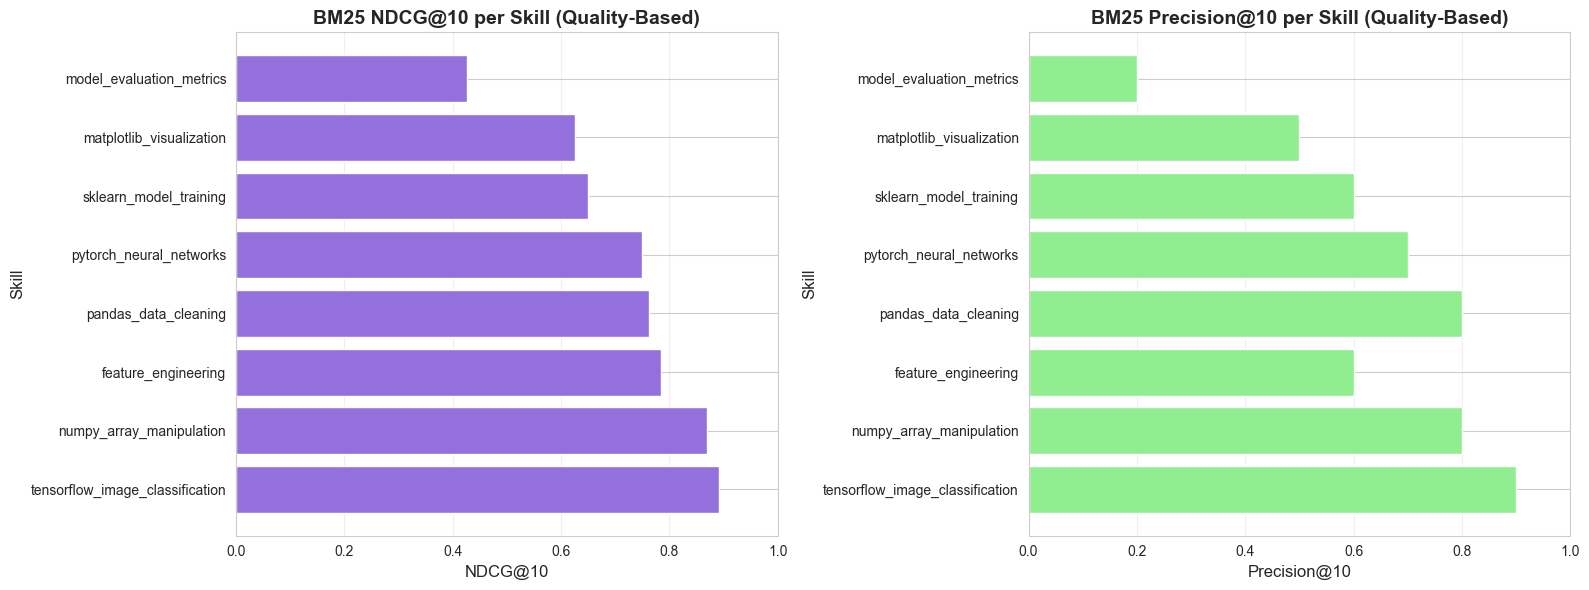

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

bm25_quality_sorted = bm25_quality_eval.sort_values('ndcg_at_k', ascending=False)

axes[0].barh(bm25_quality_sorted['skill_id'], bm25_quality_sorted['ndcg_at_k'], color='mediumpurple')
axes[0].set_xlabel('NDCG@10', fontsize=12)
axes[0].set_ylabel('Skill', fontsize=12)
axes[0].set_title('BM25 NDCG@10 per Skill (Quality-Based)', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(bm25_quality_sorted['skill_id'], bm25_quality_sorted['precision_at_k'], color='lightgreen')
axes[1].set_xlabel('Precision@10', fontsize=12)
axes[1].set_ylabel('Skill', fontsize=12)
axes[1].set_title('BM25 Precision@10 per Skill (Quality-Based)', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(EVAL_DIR / 'bm25_quality_per_skill.png', dpi=150, bbox_inches='tight')
plt.show()

### BM25 Quality-Based Results Summary

In [ ]:
bm25_avg_precision_quality = bm25_quality_eval['precision_at_k'].mean()
bm25_avg_ndcg_quality = bm25_quality_eval['ndcg_at_k'].mean()
bm25_quality_metrics = {
    'model': 'BM25',
    'precision_at_10': bm25_avg_precision_quality,
    'ndcg_at_10': bm25_avg_ndcg_quality
}

print("="*80)
print("BM25 QUALITY-BASED PERFORMANCE (K=10)")
print("="*80)
print(f"Average Precision@10: {bm25_avg_precision_quality:.3f}")
print(f"Average NDCG@10:      {bm25_avg_ndcg_quality:.3f}")

print("\n" + "="*80)
print("Per-Skill Performance:")
print("="*80)
bm25_quality_skill_perf = bm25_quality_eval[['skill_id', 'precision_at_k', 'ndcg_at_k']].sort_values('ndcg_at_k', ascending=False)
print(bm25_quality_skill_perf.to_string(index=False))

BM25 QUALITY-BASED PERFORMANCE (K=10)
Average Precision@10: 0.638
Average NDCG@10:      0.720

Per-Skill Performance:
                       skill_id  precision_at_k  ndcg_at_k
tensorflow_image_classification             0.9   0.892208
       numpy_array_manipulation             0.8   0.869915
            feature_engineering             0.6   0.784764
           pandas_data_cleaning             0.8   0.762323
        pytorch_neural_networks             0.7   0.749196
         sklearn_model_training             0.6   0.649564
       matplotlib_visualization             0.5   0.626058
       model_evaluation_metrics             0.2   0.425620


In [ ]:
sbert_avg_precision_quality = sbert_quality_eval['precision_at_k'].mean()
sbert_avg_ndcg_quality = sbert_quality_eval['ndcg_at_k'].mean()
sbert_quality_metrics = {
    'model': 'SBERT',
    'precision_at_10': sbert_avg_precision_quality,
    'ndcg_at_10': sbert_avg_ndcg_quality
}

print("="*80)
print("SBERT QUALITY-BASED PERFORMANCE (K=10)")
print("="*80)
print(f"Average Precision@10: {sbert_avg_precision_quality:.3f}")
print(f"Average NDCG@10:      {sbert_avg_ndcg_quality:.3f}")

print("\n" + "="*80)
print("Per-Skill Performance:")
print("="*80)
sbert_quality_skill_perf = sbert_quality_eval[['skill_id', 'precision_at_k', 'ndcg_at_k']].sort_values('ndcg_at_k', ascending=False)
print(sbert_quality_skill_perf.to_string(index=False))

SBERT QUALITY-BASED PERFORMANCE (K=10)
Average Precision@10: 0.637
Average NDCG@10:      0.782

Per-Skill Performance:
                       skill_id  precision_at_k  ndcg_at_k
        pytorch_neural_networks             0.8   0.882943
tensorflow_image_classification             0.8   0.861359
       numpy_array_manipulation             0.8   0.846386
       matplotlib_visualization             0.7   0.807692
           pandas_data_cleaning             0.7   0.739340
            feature_engineering             0.2   0.722393
         sklearn_model_training             0.6   0.705483
       model_evaluation_metrics             0.5   0.687507


### Visualize SBERT Quality-Based Results

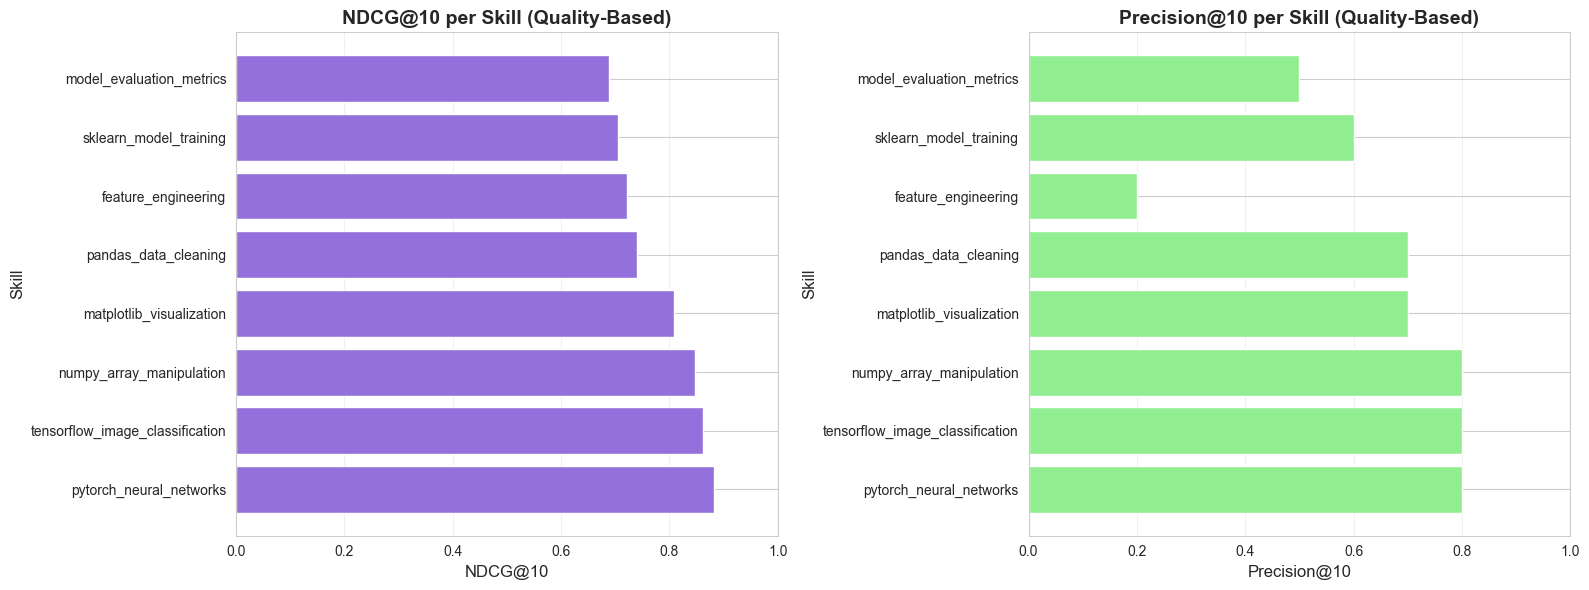

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

quality_sorted = sbert_quality_eval.sort_values('ndcg_at_k', ascending=False)

axes[0].barh(quality_sorted['skill_id'], quality_sorted['ndcg_at_k'], color='mediumpurple')
axes[0].set_xlabel('NDCG@10', fontsize=12)
axes[0].set_ylabel('Skill', fontsize=12)
axes[0].set_title('NDCG@10 per Skill (Quality-Based)', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(quality_sorted['skill_id'], quality_sorted['precision_at_k'], color='lightgreen')
axes[1].set_xlabel('Precision@10', fontsize=12)
axes[1].set_ylabel('Skill', fontsize=12)
axes[1].set_title('Precision@10 per Skill (Quality-Based)', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(EVAL_DIR / 'sbert_quality_per_skill.png', dpi=150, bbox_inches='tight')
plt.show()

### Evaluate Cross-Encoder Rankings (Quality-Based)

In [ ]:
print("Evaluating Cross-Encoder with overall quality scores (K=10)...")
crossencoder_quality_eval = evaluate_quality_rankings(zeroshot_rankings, labels_df, k=10, quality_threshold=3.5)

print(f"\n Evaluated {len(crossencoder_quality_eval)} skills")
print("\nResults:")
print(crossencoder_quality_eval[['skill_id', 'precision_at_k', 'ndcg_at_k']].to_string(index=False))

Evaluating Cross-Encoder with overall quality scores (K=10)...

 Evaluated 8 skills

Results:
                       skill_id  precision_at_k  ndcg_at_k
            feature_engineering             0.6   0.866990
       matplotlib_visualization             0.8   0.845753
       model_evaluation_metrics             0.7   0.901994
       numpy_array_manipulation             0.9   0.914247
           pandas_data_cleaning             0.8   0.813005
        pytorch_neural_networks             0.9   0.930336
         sklearn_model_training             0.7   0.844460
tensorflow_image_classification             0.9   0.898885


In [ ]:
crossencoder_avg_precision_quality = crossencoder_quality_eval['precision_at_k'].mean()
crossencoder_avg_ndcg_quality = crossencoder_quality_eval['ndcg_at_k'].mean()
crossencoder_quality_metrics = {
    'model': 'Cross-Encoder (Zero-Shot)',
    'precision_at_10': crossencoder_avg_precision_quality,
    'ndcg_at_10': crossencoder_avg_ndcg_quality
}

print("="*80)
print("CROSS-ENCODER (ZERO-SHOT) QUALITY-BASED PERFORMANCE (K=10)")
print("="*80)
print(f"Average Precision@10: {crossencoder_avg_precision_quality:.3f}")
print(f"Average NDCG@10:      {crossencoder_avg_ndcg_quality:.3f}")

print("\n" + "="*80)
print("Per-Skill Performance:")
print("="*80)
crossencoder_quality_skill_perf = crossencoder_quality_eval[['skill_id', 'precision_at_k', 'ndcg_at_k']].sort_values('ndcg_at_k', ascending=False)
print(crossencoder_quality_skill_perf.to_string(index=False))

CROSS-ENCODER (ZERO-SHOT) QUALITY-BASED PERFORMANCE (K=10)
Average Precision@10: 0.788
Average NDCG@10:      0.877

Per-Skill Performance:
                       skill_id  precision_at_k  ndcg_at_k
        pytorch_neural_networks             0.9   0.930336
       numpy_array_manipulation             0.9   0.914247
       model_evaluation_metrics             0.7   0.901994
tensorflow_image_classification             0.9   0.898885
            feature_engineering             0.6   0.866990
       matplotlib_visualization             0.8   0.845753
         sklearn_model_training             0.7   0.844460
           pandas_data_cleaning             0.8   0.813005


In [ ]:
### Evaluate Cross-Encoder (Fine-Tuned) Rankings (Quality-Based)
if finetuned_rankings is not None:
    print("Evaluating Cross-Encoder (Fine-Tuned) with overall quality scores (K=10)...")
    finetuned_quality_eval = evaluate_quality_rankings(finetuned_rankings, labels_df, k=10, quality_threshold=3.5)

    print(f"\n Evaluated {len(finetuned_quality_eval)} skills")
    print("\nResults:")
    print(finetuned_quality_eval[['skill_id', 'precision_at_k', 'ndcg_at_k']].to_string(index=False))

    # Summary
    finetuned_avg_precision_quality = finetuned_quality_eval['precision_at_k'].mean()
    finetuned_avg_ndcg_quality = finetuned_quality_eval['ndcg_at_k'].mean()
    finetuned_quality_metrics = {
        'model': 'Cross-Encoder (Fine-Tuned)',
        'precision_at_10': finetuned_avg_precision_quality,
        'ndcg_at_10': finetuned_avg_ndcg_quality
    }

    print("="*80)
    print("CROSS-ENCODER (FINE-TUNED) QUALITY-BASED PERFORMANCE (K=10)")
    print("="*80)
    print(f"Average Precision@10: {finetuned_avg_precision_quality:.3f}")
    print(f"Average NDCG@10:      {finetuned_avg_ndcg_quality:.3f}")
else:
    finetuned_avg_precision_quality = 0
    finetuned_avg_ndcg_quality = 0
    finetuned_quality_metrics = {'model': 'Cross-Encoder (Fine-Tuned)', 'precision_at_10': 0, 'ndcg_at_10': 0}

Evaluating Cross-Encoder (Fine-Tuned) with overall quality scores (K=10)...

 Evaluated 8 skills

Results:
                       skill_id  precision_at_k  ndcg_at_k
            feature_engineering             0.8   0.943988
       matplotlib_visualization             1.0   0.943154
       model_evaluation_metrics             1.0   0.972446
       numpy_array_manipulation             1.0   0.968212
           pandas_data_cleaning             1.0   0.969742
        pytorch_neural_networks             1.0   0.963736
         sklearn_model_training             1.0   0.952427
tensorflow_image_classification             1.0   0.956625
CROSS-ENCODER (FINE-TUNED) QUALITY-BASED PERFORMANCE (K=10)
Average Precision@10: 0.975
Average NDCG@10:      0.959


---
## Compare All Models: BM25 vs SBERT vs Cross-Encoder

MODEL COMPARISON: BM25 vs SBERT vs Cross-Encoder (Zero-Shot vs Fine-Tuned)
                     model evaluation  precision_at_10  ndcg_at_10
                      BM25  Relevance           0.7000    0.743374
                     SBERT  Relevance           0.7000    0.809917
 Cross-Encoder (Zero-Shot)  Relevance           0.8750    0.905106
                      BM25    Quality           0.6375    0.719956
                     SBERT    Quality           0.6375    0.781638
 Cross-Encoder (Zero-Shot)    Quality           0.7875    0.876959
Cross-Encoder (Fine-Tuned)  Relevance           0.9750    0.990388
Cross-Encoder (Fine-Tuned)    Quality           0.9750    0.958791


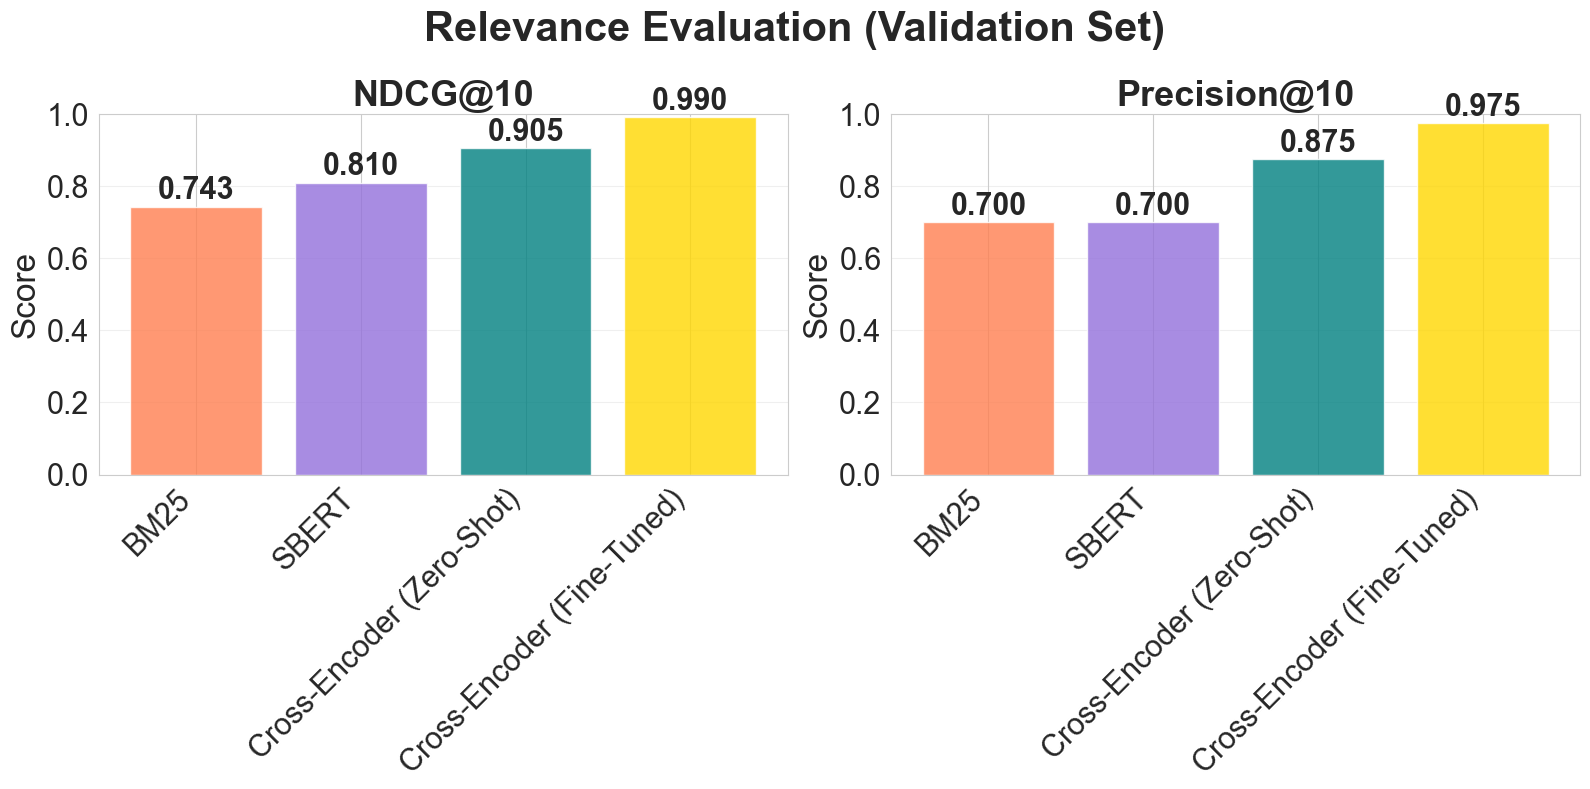

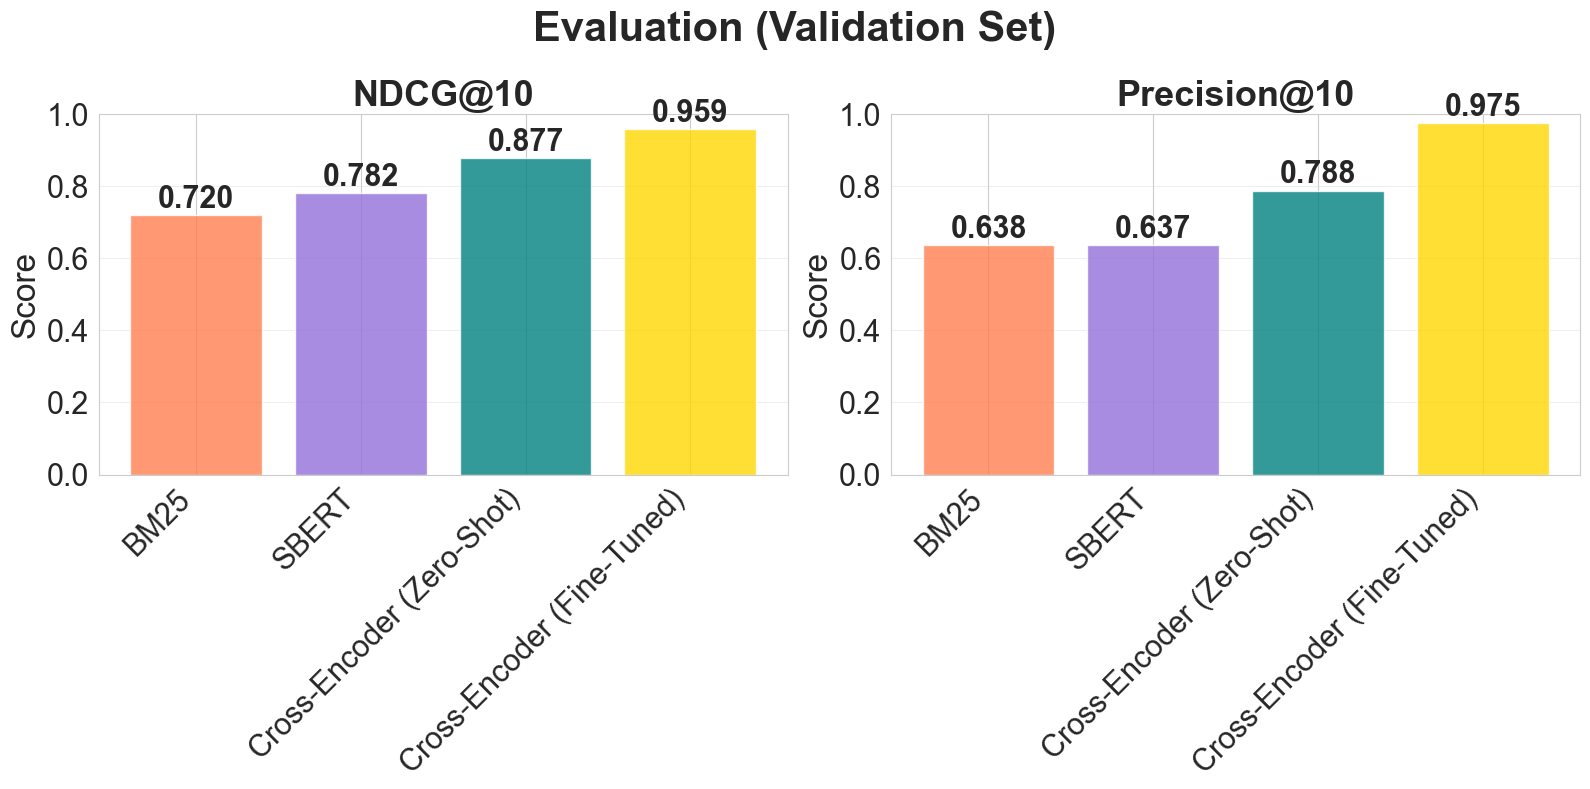

In [ ]:
comparison_records = [
    {'model': 'BM25', 'evaluation': 'Relevance', 'precision_at_10': bm25_avg_precision, 'ndcg_at_10': bm25_avg_ndcg},
    {'model': 'SBERT', 'evaluation': 'Relevance', 'precision_at_10': sbert_avg_precision, 'ndcg_at_10': sbert_avg_ndcg},
    {'model': 'Cross-Encoder (Zero-Shot)', 'evaluation': 'Relevance', 'precision_at_10': crossencoder_avg_precision, 'ndcg_at_10': crossencoder_avg_ndcg},
    {'model': 'BM25', 'evaluation': 'Quality', 'precision_at_10': bm25_avg_precision_quality, 'ndcg_at_10': bm25_avg_ndcg_quality},
    {'model': 'SBERT', 'evaluation': 'Quality', 'precision_at_10': sbert_avg_precision_quality, 'ndcg_at_10': sbert_avg_ndcg_quality},
    {'model': 'Cross-Encoder (Zero-Shot)', 'evaluation': 'Quality', 'precision_at_10': crossencoder_avg_precision_quality, 'ndcg_at_10': crossencoder_avg_ndcg_quality},
]

if finetuned_rankings is not None:
    comparison_records.append({'model': 'Cross-Encoder (Fine-Tuned)', 'evaluation': 'Relevance', 'precision_at_10': finetuned_avg_precision, 'ndcg_at_10': finetuned_avg_ndcg})
    comparison_records.append({'model': 'Cross-Encoder (Fine-Tuned)', 'evaluation': 'Quality', 'precision_at_10': finetuned_avg_precision_quality, 'ndcg_at_10': finetuned_avg_ndcg_quality})

comparison_df = pd.DataFrame(comparison_records)

print("="*80)
print("MODEL COMPARISON: BM25 vs SBERT vs Cross-Encoder (Zero-Shot vs Fine-Tuned)")
print("="*80)
print(comparison_df.to_string(index=False))

relevance_df = comparison_df[comparison_df['evaluation'] == 'Relevance']
quality_df = comparison_df[comparison_df['evaluation'] == 'Quality']

colors = ['coral', 'mediumpurple', 'teal', 'gold']

# --- 1. Relevance Evaluation (NDCG & Precision) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Relevance Evaluation (Validation Set)', fontsize=30, fontweight='bold')

# NDCG@10 (Relevance)
x_pos = range(len(relevance_df))
axes[0].bar(x_pos, relevance_df['ndcg_at_10'], color=colors[:len(relevance_df)], alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(relevance_df['model'], rotation=45, ha='right', fontsize=22)
axes[0].set_title('NDCG@10', fontsize=26, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Score', fontsize=24)
axes[0].tick_params(axis='y', labelsize=22)
axes[0].grid(axis='y', alpha=0.3)
for i, (_, row) in enumerate(relevance_df.iterrows()):
    axes[0].text(i, row['ndcg_at_10'] + 0.02, f"{row['ndcg_at_10']:.3f}", ha='center', fontweight='bold', fontsize=22)

# Precision@10 (Relevance)
axes[1].bar(x_pos, relevance_df['precision_at_10'], color=colors[:len(relevance_df)], alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(relevance_df['model'], rotation=45, ha='right', fontsize=22)
axes[1].set_title('Precision@10', fontsize=26, fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].set_ylabel('Score', fontsize=24)
axes[1].tick_params(axis='y', labelsize=22)
axes[1].grid(axis='y', alpha=0.3)
for i, (_, row) in enumerate(relevance_df.iterrows()):
    axes[1].text(i, row['precision_at_10'] + 0.02, f"{row['precision_at_10']:.3f}", ha='center', fontweight='bold', fontsize=22)

plt.tight_layout()
plt.subplots_adjust(top=0.85) # Adjust top to make room for suptitle
plt.savefig(EVAL_DIR / 'relevance_evaluation_validation.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 2. Quality Evaluation (NDCG & Precision) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Evaluation (Validation Set)', fontsize=30, fontweight='bold')

# NDCG@10 (Quality)
x_pos = range(len(quality_df))
axes[0].bar(x_pos, quality_df['ndcg_at_10'], color=colors[:len(quality_df)], alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(quality_df['model'], rotation=45, ha='right', fontsize=22)
axes[0].set_title('NDCG@10', fontsize=26, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('Score', fontsize=24)
axes[0].tick_params(axis='y', labelsize=22)
axes[0].grid(axis='y', alpha=0.3)
for i, (_, row) in enumerate(quality_df.iterrows()):
    axes[0].text(i, row['ndcg_at_10'] + 0.02, f"{row['ndcg_at_10']:.3f}", ha='center', fontweight='bold', fontsize=22)

# Precision@10 (Quality)
axes[1].bar(x_pos, quality_df['precision_at_10'], color=colors[:len(quality_df)], alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(quality_df['model'], rotation=45, ha='right', fontsize=22)
axes[1].set_title('Precision@10', fontsize=26, fontweight='bold')
axes[1].set_ylim(0, 1)
axes[1].set_ylabel('Score', fontsize=24)
axes[1].tick_params(axis='y', labelsize=22)
axes[1].grid(axis='y', alpha=0.3)
for i, (_, row) in enumerate(quality_df.iterrows()):
    axes[1].text(i, row['precision_at_10'] + 0.02, f"{row['precision_at_10']:.3f}", ha='center', fontweight='bold', fontsize=22)

plt.tight_layout()
plt.subplots_adjust(top=0.85) # Adjust top
plt.savefig(EVAL_DIR / 'quality_evaluation_validation.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Save Results

In [ ]:
# Save relevance results
bm25_eval.to_csv(EVAL_DIR / 'bm25_relevance_evaluation.csv', index=False)
sbert_eval.to_csv(EVAL_DIR / 'sbert_relevance_evaluation.csv', index=False)
crossencoder_eval.to_csv(EVAL_DIR / 'crossencoder_relevance_evaluation.csv', index=False)

if finetuned_rankings is not None:
    finetuned_eval.to_csv(EVAL_DIR / 'crossencoder_finetuned_relevance_evaluation.csv', index=False)
    print(f"Saved: {EVAL_DIR / 'crossencoder_finetuned_relevance_evaluation.csv'}")

# Save quality results
bm25_quality_eval.to_csv(EVAL_DIR / 'bm25_quality_evaluation.csv', index=False)
sbert_quality_eval.to_csv(EVAL_DIR / 'sbert_quality_evaluation.csv', index=False)
crossencoder_quality_eval.to_csv(EVAL_DIR / 'crossencoder_quality_evaluation.csv', index=False)

if finetuned_rankings is not None:
    finetuned_quality_eval.to_csv(EVAL_DIR / 'crossencoder_finetuned_quality_evaluation.csv', index=False)
    print(f" Saved: {EVAL_DIR / 'crossencoder_finetuned_quality_evaluation.csv'}")

# Save comparison summary
comparison_df.to_csv(EVAL_DIR / 'all_models_comparison.csv', index=False)
print(f" Saved: {EVAL_DIR / 'all_models_comparison.csv'}")

# Save summary
summary = {
    'k': 10,
    'relevance_threshold': RELEVANCE_THRESHOLD,
    'quality_threshold': 3.0,
    'models': {
        'bm25': {
            'relevance': bm25_relevance_metrics,
            'quality': bm25_quality_metrics
        },
        'sbert': {
            'relevance': sbert_relevance_metrics,
            'quality': sbert_quality_metrics
        },
        'crossencoder_zeroshot': {
            'relevance': crossencoder_relevance_metrics,
            'quality': crossencoder_quality_metrics
        },
        'crossencoder_finetuned': {
            'relevance': finetuned_relevance_metrics,
            'quality': finetuned_quality_metrics
        }
    }
}

with open(EVAL_DIR / 'evaluation_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Saved: {EVAL_DIR / 'evaluation_summary.json'}")